In [3]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import CatBoostEncoder
from importlib import reload
import pandas as pd
import model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor
)
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
reload(ms)

<module 'model_selection' from 'e:\\Ames-Housing-Price-Predictor\\demo\\model_selection.py'>

## Load dataset

In [4]:
df = pd.read_parquet('../data/processed/04_outlier_handling.parquet')

## Pipeline

### Column Selector

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        return df[self.columns]

### Encoder

In [6]:
class CatBoostEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = None
        self.categorical_cols = []
        self.fitted = False
        self.target = 'saleprice'
        
    def fit(self, df: pd.DataFrame, y = None):
        # Detecta columnas categóricas automáticamente
        self.categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
        if not self.categorical_cols:
            raise ValueError("No se encontraron columnas categóricas en el DataFrame.")

        self.encoder = CatBoostEncoder(cols=self.categorical_cols, random_state=0)
        self.encoder.fit(df[self.categorical_cols], df[self.target])
        self.fitted = True
        return self

    def transform(self, df: pd.DataFrame):
        if not self.fitted:
            raise RuntimeError("Debes llamar primero a .fit() antes de usar .transform().")
        
        df_encoded = df.copy()
        df_encoded[self.categorical_cols] = self.encoder.transform(df[self.categorical_cols])
        
        return df_encoded

### Feature Engineering 

In [7]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, df, y=None):
        return self

    def transform(self, df):
        df = df.copy()
        # Crear nuevas columnas
        df["total_sqft"] = df["1st_flr_sf"] + df["2nd_flr_sf"] + df["total_bsmt_sf"]
        df["overall_score"] = df["overall_qual"] * df["overall_cond"]
        df["total_bathrooms"] = (df["full_bath"] + 0.5*df["half_bath"] + df["bsmt_full_bath"] + 0.5*df["bsmt_half_bath"])
        return df

## Main Code

In [8]:
colselector1 = ColumnSelector(['1st_flr_sf', '2nd_flr_sf', 'total_bsmt_sf', 'overall_qual', 'overall_cond', 'neighborhood', 'gr_liv_area','full_bath', 'half_bath', 'bsmt_full_bath', 'bsmt_half_bath', 'garage_cars', 'kitchen_qual','garage_area', 'saleprice'])

df_transformed = colselector1.fit_transform(df)

In [9]:
catencoder = CatBoostEncoderWrapper()
df_transformed = catencoder.fit_transform(df_transformed)

In [10]:
featengine = FeatureEngineering()
df_transformed = featengine.fit_transform(df_transformed)

In [11]:
colselector2 = ColumnSelector(['total_bsmt_sf', 'overall_qual', 'neighborhood', 'gr_liv_area','total_bathrooms', 'overall_score', 'garage_cars', 'kitchen_qual','garage_area', 'saleprice'])

df = colselector2.fit_transform(df_transformed)

In [13]:
target = 'saleprice'
x = df.drop(columns=[target])
y = df[target]
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.1,
    random_state=17,
)

In [27]:
df

,total_bsmt_sf,overall_qual,neighborhood,gr_liv_area,total_bathrooms,overall_score,garage_cars,kitchen_qual,garage_area,saleprice
0,1080.0,6,145177.752388,1656.0,2.0,30,2,139577.537164,528.0,215000.0
1,882.0,5,145177.752388,896.0,1.0,30,1,139577.537164,730.0,105000.0
2,1329.0,6,145177.752388,1329.0,1.5,36,1,210809.708923,312.0,172000.0
3,2110.0,7,145177.752388,2110.0,3.5,35,2,336579.422622,522.0,244000.0
4,928.0,5,190587.235302,1629.0,2.5,25,2,139577.537164,482.0,189900.0
...,...,...,...,...,...,...,...,...,...,...
2925,1003.0,6,162388.104870,1003.0,2.0,36,2,139577.537164,588.0,142500.0
2926,864.0,5,162388.104870,902.0,2.0,25,2,139577.537164,484.0,131000.0
2927,912.0,5,162388.104870,970.0,1.5,25,0,139577.537164,0.0,132000.0
2928,1389.0,5,162388.104870,1389.0,2.0,25,2,139577.537164,418.0,170000.0


In [74]:
models = {
    'Bagging Regressor': BaggingRegressor(),
    'Random Forest': RandomForestRegressor(n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(verbose=0),
    'CatBoost': CatBoostRegressor(task_type='GPU', devices='0', verbose=0),
    'LightGBM': LGBMRegressor(device='gpu', n_jobs=-1, verbose=-1),
    "XGBoost": XGBRegressor(tree_method="hist", device="cuda")
}

In [75]:
reload(ms)
regression_metrics, predictions_dict, importances_dict = ms.model_predict(models, x_train, x_test, y_train, y_test)


✅ Testing Bagging Regressor...
MAE: 18104.710227531286 | MSE: 670957109.0921372 | RMSE: 25902.839788180314 | R²: 0.9032619467909845 | RMSLE: 0.1478510130437996 | MAPE: 0.10856549822666024
--------------------------------------------------

✅ Testing Random Forest...
MAE: 17538.71378956713 | MSE: 669260547.9558349 | RMSE: 25870.070505428368 | R²: 0.9035065556031603 | RMSLE: 0.14751060913183722 | MAPE: 0.10605836399250393
--------------------------------------------------

✅ Testing Gradient Boosting...
MAE: 17431.237878242864 | MSE: 611169292.8308241 | RMSE: 24721.838378867058 | R²: 0.9118821057733726 | RMSLE: 0.13816356932249885 | MAPE: 0.10288687678248261
--------------------------------------------------

✅ Testing CatBoost...
MAE: 18244.502023296405 | MSE: 751323107.7125982 | RMSE: 27410.27376208779 | R²: 0.8916748421230553 | RMSLE: 0.1392722114109087 | MAPE: 0.10403163092511183
--------------------------------------------------

✅ Testing LightGBM...
MAE: 17474.667467464635 | MSE:

e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [16:23:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


## Model Evaluation

### Regression Metrics

In [76]:
regression_metrics

,Model,MAE,MSE,RMSE,R²,RMSLE,MAPE
0,Bagging Regressor,18104.710228,6.709571e+08,25902.839788,0.903262,0.147851,0.108565
1,Random Forest,17538.713790,6.692605e+08,25870.070505,0.903507,0.147511,0.106058
2,Gradient Boosting,17431.237878,6.111693e+08,24721.838379,0.911882,0.138164,0.102887
3,CatBoost,18244.502023,7.513231e+08,27410.273762,0.891675,0.139272,0.104032
4,LightGBM,17474.667467,6.732923e+08,25947.876572,0.902925,0.141457,0.102368
5,XGBoost,18809.737681,7.822277e+08,27968.333255,0.887219,0.148436,0.109180


### Feature Importances

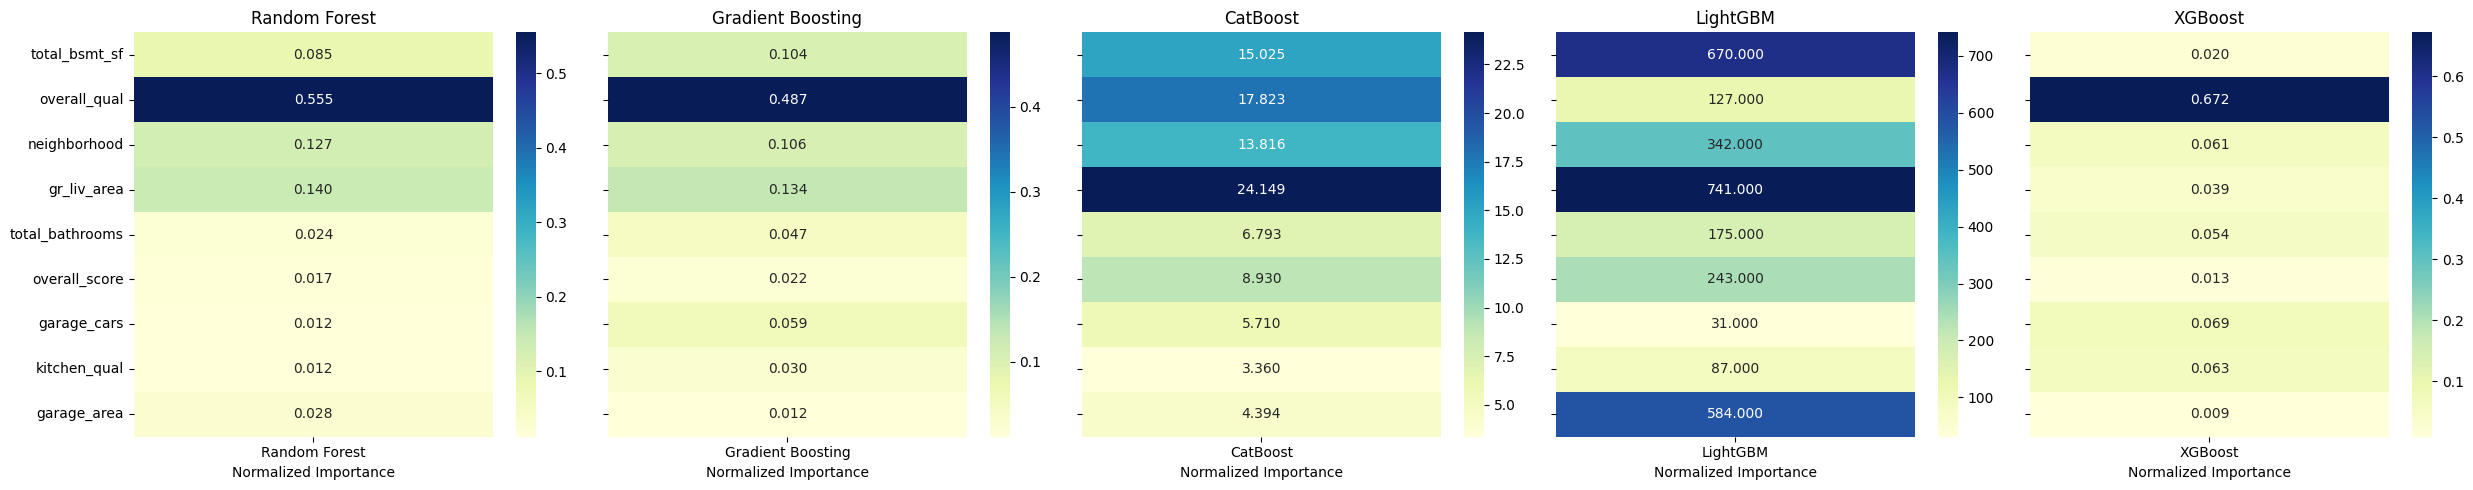

In [77]:
ms.plot_feature_importances(df.drop(columns=target).columns, importances_dict)

### Residuals Plot

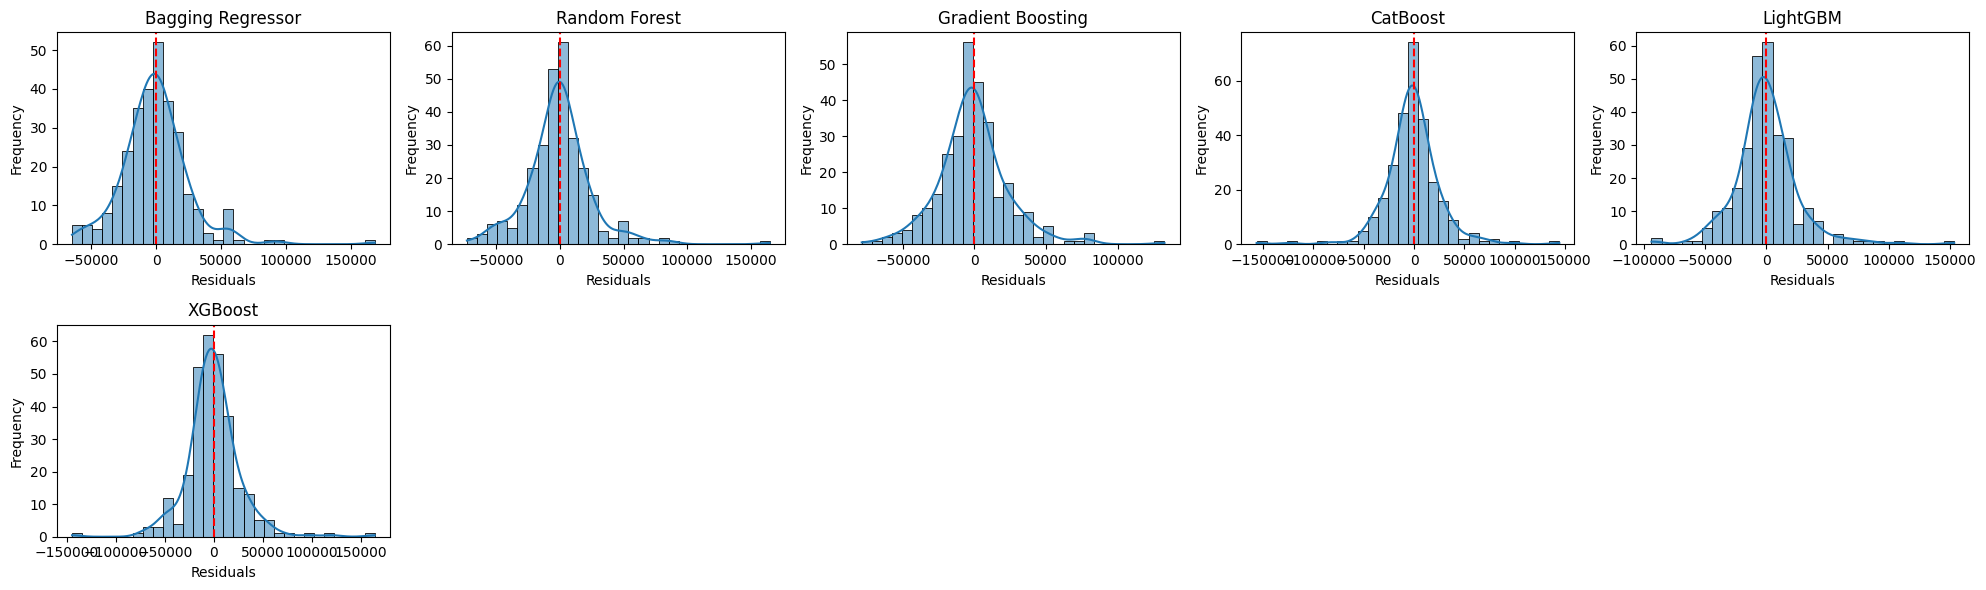

In [80]:
reload(ms)
ms.plot_residuals(y_test, predictions_dict, n_cols=5)

### Scatter Plot

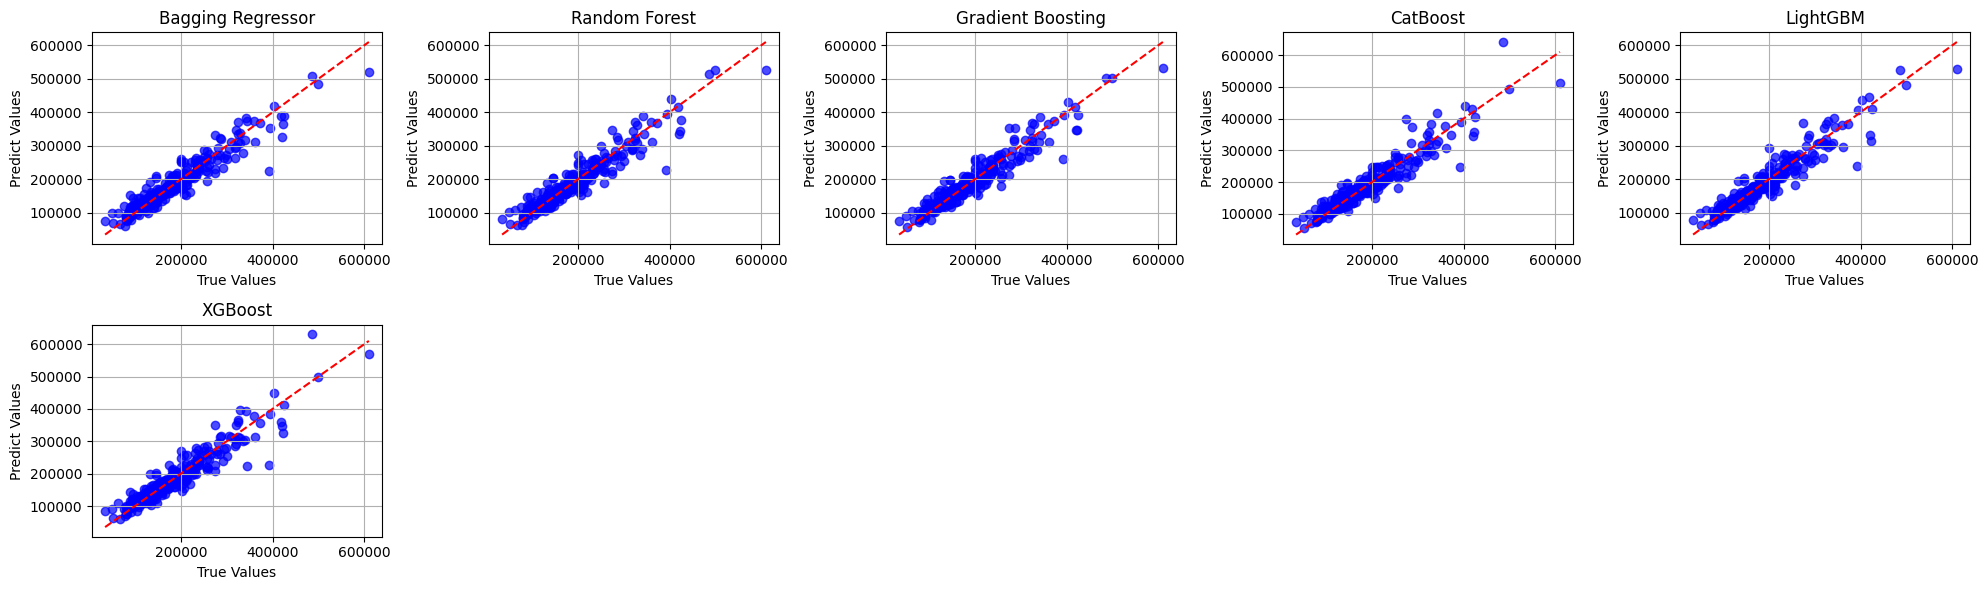

In [81]:
reload(ms)
ms.scatter_plot(y_test, predictions_dict, n_cols=5)

### Learning Curve

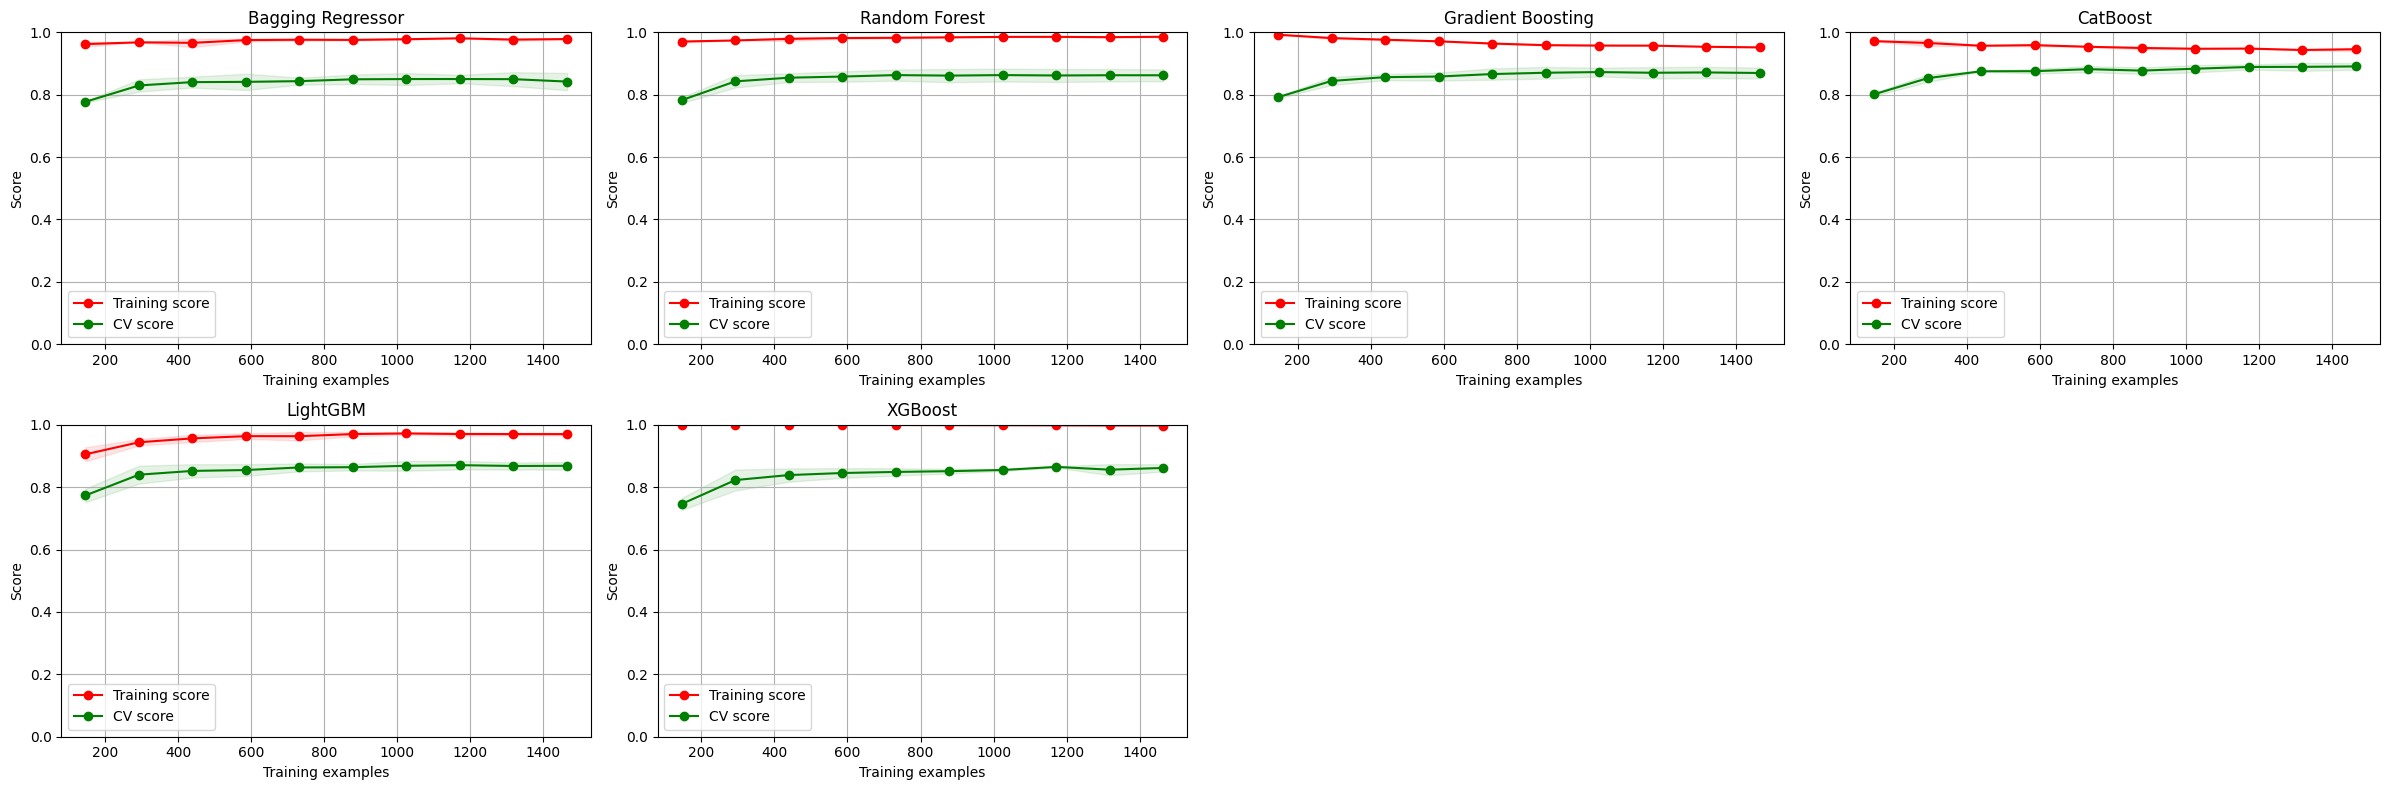

In [82]:
reload(ms)
learning_curve_summary = ms.learning_curves_regression(models, x, y, cv=2, scoring='r2', cols=4)

### Learning Curve Summary

In [85]:
learning_curve_summary

,Model,Train score,CV score,Gap,Best n_samples
0,Bagging Regressor,0.978536,0.842119,0.136417,1172
1,Random Forest,0.985725,0.862326,0.123399,1025
2,Gradient Boosting,0.951805,0.869610,0.082195,1025
3,CatBoost,0.945744,0.890700,0.055044,1465
4,LightGBM,0.970245,0.868601,0.101645,1172
5,XGBoost,0.997860,0.861854,0.136006,1172


### Best Model

The best model is ``CatBoost`` because it has the smallest gap between the training and cross-validation scores, indicating better generalization and less overfitting compared to the other models.

Additionally, ``CatBoost`` achieves the highest cross-validation score ``(0.8907)`` among all models, further supporting its superior generalization performance.

In [86]:
models['CatBoost'].save_model("../models/catboost_model_demo.cbm")

## Hyperparameter tuning

In [16]:
models = {
    'CatBoost': CatBoostRegressor(task_type='GPU', devices='0', verbose=0),
}

In [17]:
from scipy.stats import loguniform, randint

param_dist = {
    'CatBoost': {
        'iterations':   randint(100, 300),
        'learning_rate': loguniform(1e-3, 0.2),
        'depth':        randint(4, 8),
        'l2_leaf_reg':  [1, 3, 5, 10]
    }
}


In [18]:
reload(ms)
models_pro = ms.regression_hyperparameter_tuning(x_train, y_train, models, param_dist, cv=2, n_iter = 50)

✅ Tuning hyperparameter for CatBoost...
Best hyperparameters for CatBoost: {'depth': 5, 'iterations': 296, 'l2_leaf_reg': 10, 'learning_rate': np.float64(0.0972672319015516)}



In [19]:
reload(ms)
regression_metrics, predictions_dict, importances_dict = ms.model_predict(models_pro, x_train, x_test, y_train, y_test)


✅ Testing CatBoost...
MAE: 17337.859679306923 | MSE: 620432256.4522651 | RMSE: 24908.477602058803 | R²: 0.9105465791718338 | RMSLE: 0.1377368334974998 | MAPE: 0.10170533994243515
--------------------------------------------------


## Model Evaluation

In [20]:
regression_metrics

,Model,MAE,MSE,RMSE,R²,RMSLE,MAPE
0,CatBoost,17337.859679,6.204323e+08,24908.477602,0.910547,0.137737,0.101705


### Residuals Plot

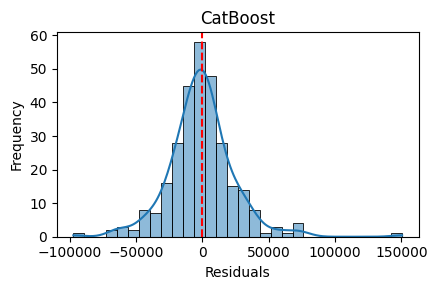

In [21]:
reload(ms)
ms.plot_residuals(y_test, predictions_dict, n_cols=5)

### Scatter Plot

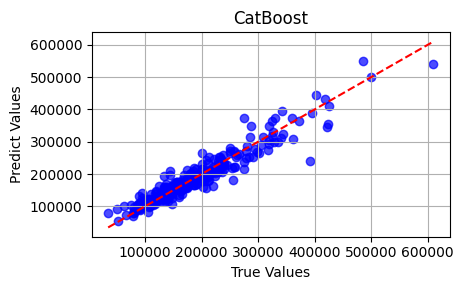

In [22]:
reload(ms)
ms.scatter_plot(y_test, predictions_dict, n_cols=5)

### Feature Importance

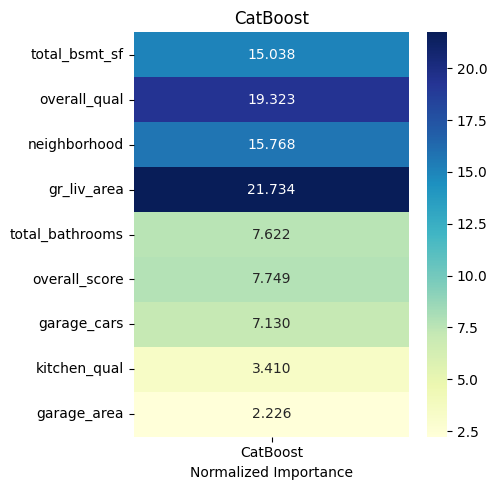

In [23]:
reload(ms)
ms.plot_feature_importances(x.columns,importances_dict)

### Learning Curve

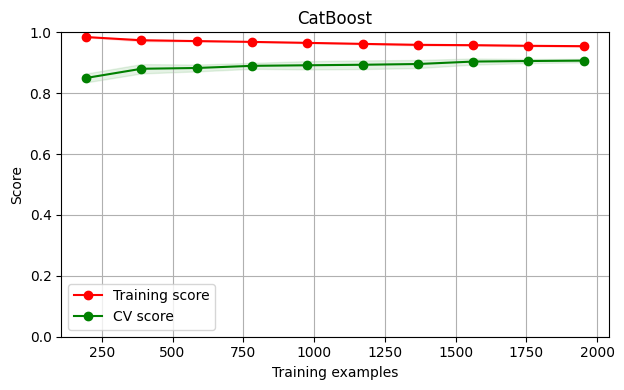

In [24]:
reload(ms)
learning_curve_summary = ms.learning_curves_regression(models_pro, x, y, cv=3, scoring='r2', cols=2)

### Learning Curve Summary

In [25]:
learning_curve_summary

,Model,Train score,CV score,Gap,Best n_samples
0,CatBoost,0.954523,0.907045,0.047477,1953


### Best Model

In [ ]:
models_pro['CatBoost'].save_model('../models/catboost_model_demo_pro.cbm')
models_pro['CatBoost'].save_model('../docker/app/catboost_model_demo_pro.cbm')